In [13]:
# Импорты
from typing import List
import math
import random
import itertools
import tqdm
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import cv2 
import numpy as np
from PIL import Image, ImageEnhance


In [26]:
Vector = List[float]

def num_differences(v1: Vector, v2: Vector) -> int:
    assert len(v1) == len(v2)
    return len([x1 for x1, x2 in zip(v1, v2) if x1 != x2])

assert num_differences([1, 2, 3], [2, 1, 3]) == 2
assert num_differences([1, 2], [1, 2]) == 0

In [27]:
def vector_sum(vectors: List[Vector]) -> Vector:
    """Суммирует все соответствующие элементы"""
    #проверить что векторы не пустые
    assert vectors, "векторы не представлены!"
    #проверить что векторы имеют одинаковый размер
    num_elements = len(vectors[0])
    assert all(len(v) == num_elements for v in vectors), "разные размеры!"
    # i-й элеметн результата является суммой каждого элемента vector[i]
    return [sum(vector[i] for vector in vectors) for i in range(num_elements)]

assert vector_sum([[1, 2], [3, 4], [5, 6], [7, 8]]) == [16,20]


In [28]:
def scalar_multiply(c:float, v:Vector):
    """Умножает каждый элемент на с"""
    return[c * v_i for v_i in v]

assert scalar_multiply(2, [1, 2, 3]) == [2, 4, 6]

In [29]:
def vector_mean(vectors: List[Vector]) -> Vector:
    """Вычисление поэлементное среднее арифметическое"""
    n = len(vectors)
    return scalar_multiply(1/n, vector_sum(vectors))

assert vector_mean([[1, 2], [3, 4], [5, 6]]) == [3, 4]

In [30]:
def dot(v: Vector, w: Vector) -> float:
    """Вычисляет v_1 * w_1 + ... v_n * w_n"""
    assert len(v) == len(w), "векторы должны иметь одинковую длину"

    return sum(v_i * w_i for v_i, w_i in zip(v,w))

assert dot([1, 2, 3], [4, 5, 6]) == 32

In [31]:
def sum_of_squares(v: Vector) -> float:
    """Возращает v_1 * v_1 + ... + v_n * v_n"""
    return dot(v, v)

assert sum_of_squares([1, 2, 3]) == 14

In [32]:
def subtract(v: Vector, w: Vector) -> Vector:
    """Вычитает соответствующие элементы"""
    assert len(v) == len(w), "векторы должны иметь одинаковую длину"
    return [v_i - w_i for v_i, w_i in zip(v, w)]

assert subtract([5, 7, 9], [4, 5, 6]) == [1, 2, 3]

In [33]:
def squared_distance(v: Vector, w: Vector) -> float:
    """Вычисляет (v_1 - w_1) ** 2 + ... + (v_n - w_n) ** 2"""
    return sum_of_squares(subtract(v, w))

In [34]:
def cluster_means(k:int, inputs: List[Vector], assignments: List[int]) -> List[Vector]:
    #cluster[i] содержит входы, чье назначение равно i
    clusters = [[] for i in range(k)]
    for input, assignment in zip(inputs, assignments):
        clusters[assignment].append(input)

    #если кластер пустой, то просто взять случайную точку
    return [vector_mean(cluster) if cluster else random.choice(inputs) for cluster in clusters]


In [35]:
class KMeans:
    def __init__(self, k:int) -> None:
        self.k = k #число кластеров
        self.means = None

    def classify(self, input: Vector) -> int:
        """Вернуть индекс кластера, ближайшего к входному значению"""
        return min(range(self.k), key = lambda i: squared_distance(input, self.means[i]))

    def train(self, inputs: List[Vector]) -> None:
        # Начать со случайных значений
        assignments = [random.randrange(self.k) for _ in inputs]
        with tqdm.tqdm(itertools.count()) as t:
            for _ in t:
                #Вычислить среднее и отыскать новые значения
                self.means = cluster_means(self.k, inputs, assignments)
                new_assignments = [self.classify(input) for input in inputs]
                
                #Проверить, сколько назначений изменилось
                #и если нисколько, то работа завершена 
                num_changed = num_differences(assignments, new_assignments)
                if num_changed == 0:
                    return

                #В противном случае  оставить новые назначения
                #и вычислить новые средние
                assignments = new_assignments
                self.means = cluster_means(self.k, inputs, assignments)
                t.set_description(f"changed: {num_changed} / {len(inputs)}")
        pass

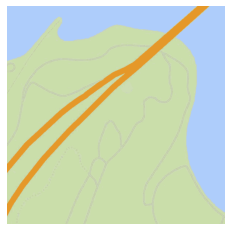

In [13]:
def recolor(pixel: Vector) -> Vector:
    cluster = clusterer.classify(pixel)
    return clusterer.means[cluster]

new_img = [[recolor(pixel) for pixel in row] for row in img]

plt.imshow(new_img)
plt.axis('off')
plt.show()

image = np.array(new_img)
im = Image.fromarray((image * 255).astype(np.uint8)).convert('RGB')
contrast = ImageEnhance.Contrast(im)
contrast.enhance(1000)
im.save("your_file.png")
im.show()
#cv2.imwrite(new_img)

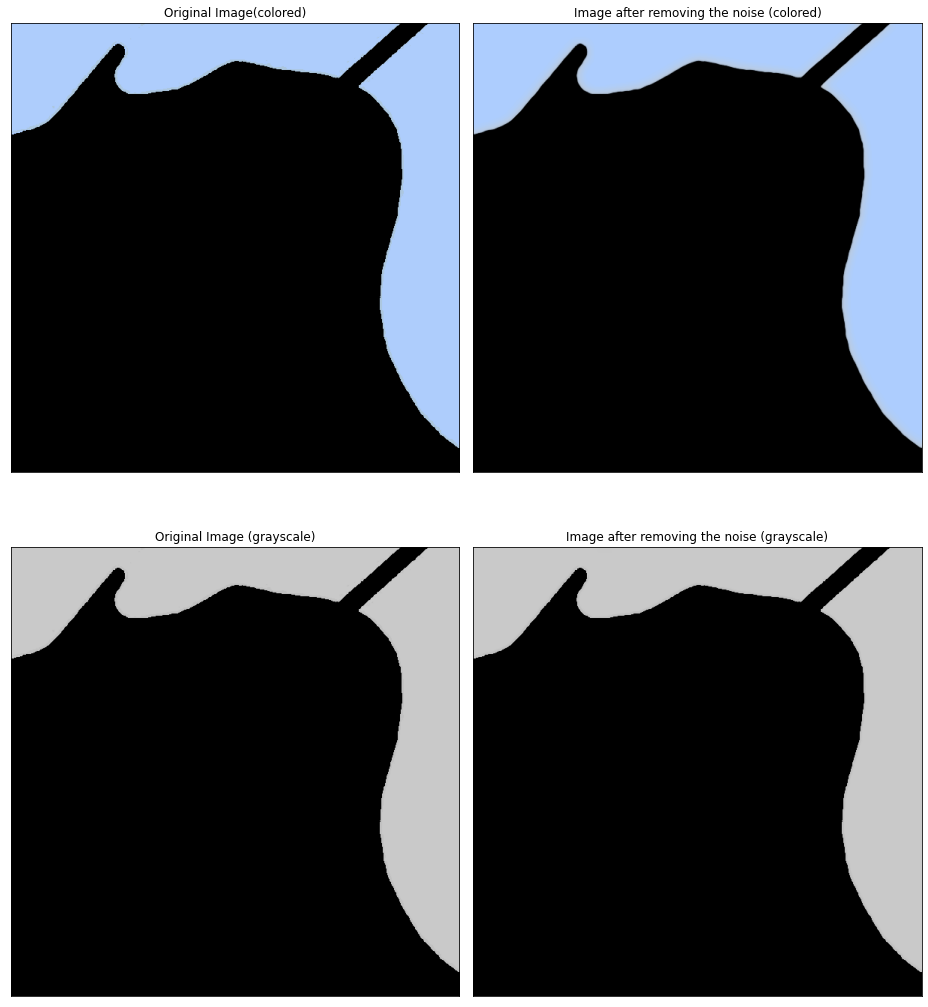

True

In [66]:
frame = cv2.imread('your_file.png')
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Threshold of blue in HSV space
lower_blue = np.array([60, 35, 140])
upper_blue = np.array([180, 255, 255])
 
# preparing the mask to overlay
mask = cv2.inRange(hsv, lower_blue, upper_blue)
     
# The black region in the mask has the value of 0,
# so when multiplied with original image removes all non-blue regions
result = cv2.bitwise_and(frame, frame, mask = mask)
 
#cv2.imwrite('frame.png', frame)
#cv2.imwrite('mask.png', mask)
cv2.imwrite('result.png', result)
image = cv2.imread('result.png',1) 

image_bw = cv2.imread('result.png',0) 

noiseless_image_bw = cv2.fastNlMeansDenoising(image_bw, None, 20, 7, 21)

noiseless_image_colored = cv2.fastNlMeansDenoisingColored(result,None,50,20,7,21) 

titles = ['Original Image(colored)','Image after removing the noise (colored)', 'Original Image (grayscale)','Image after removing the noise (grayscale)']
images = [image,noiseless_image_colored, image_bw, noiseless_image_bw]
plt.figure(figsize=(13,15))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(cv2.cvtColor(images[i],cv2.COLOR_BGR2RGB))
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()
# Sharpen the image
kernel = np.array([[-1, -1, -1],[-1, 8, -1],[-1, -1, 0]], np.float32) 
dst = cv2.filter2D(noiseless_image_colored, -1, kernel)


#Canny Edge detection
canny = cv2.Canny(dst, 30, 1000, 1)
ret, binary = cv2.threshold(noiseless_image_colored,127,255,cv2.THRESH_BINARY)

# Find contours
cnts = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
cnts_water = cnts[0] if len(cnts) == 2 else cnts[1]

# Iterate thorugh contours and draw rectangles around contours
#for c in cnts:
    #x,y,w,h = cv2.boundingRect(c)
   

    #cv2.rectangle(result, (x, y), (x + w, y + h), (255,0,255), 1)


cv2.drawContours(noiseless_image_colored,cnts_water,-1,(0,0,255),3)
#write output
cv2.imwrite('resultimagewater.png', noiseless_image_colored)


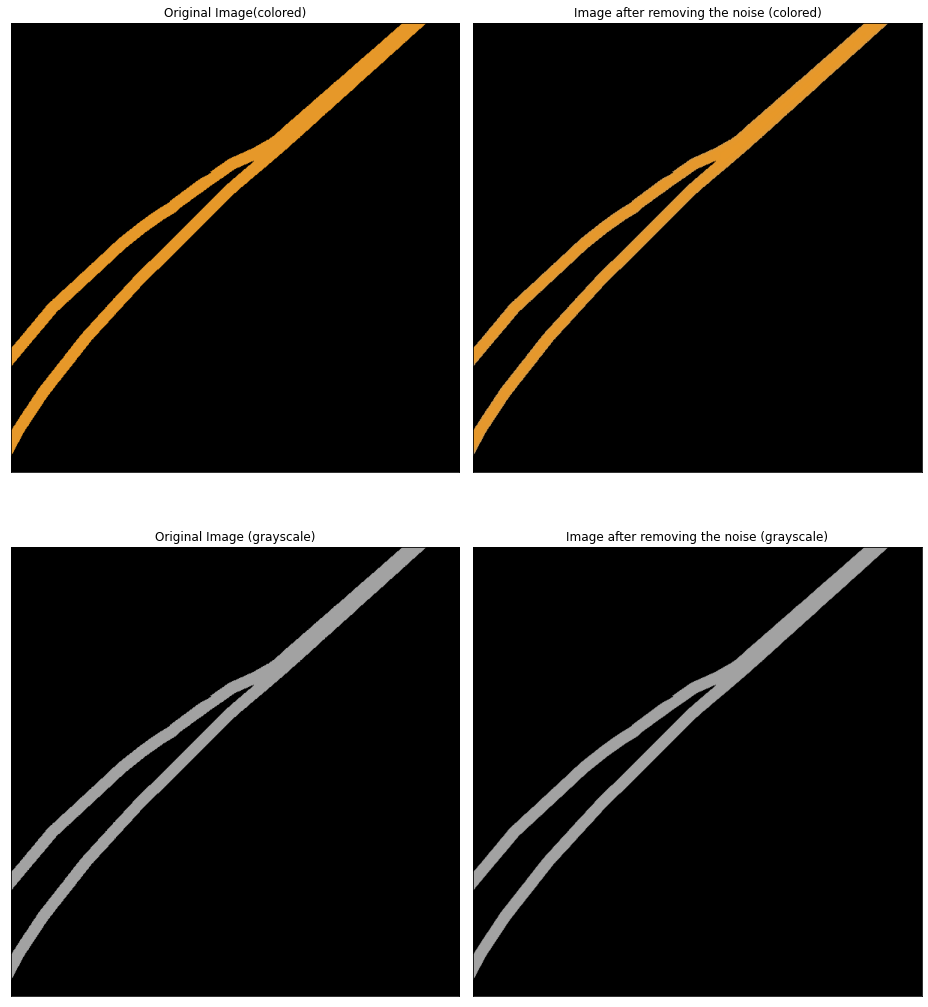

True

In [55]:
frame = cv2.imread('your_file.png')
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Threshold of white in HSV space
lower_orange = np.array([227, 151, 31])
#lower_orange = np.array([227-247, 151-159, 35-41])
upper_orange = np.array([255, 255, 255])

# preparing the mask to overlay
mask = cv2.inRange(hsv, lower_orange, upper_orange)
     
# The black region in the mask has the value of 0,
# so when multiplied with original image removes all non-blue regions
result = cv2.bitwise_and(frame, frame, mask = mask)
 
#cv2.imwrite('frame.png', frame)
#cv2.imwrite('mask.png', mask)
cv2.imwrite('result.png', result)
image = cv2.imread('result.png',1) 

image_bw = cv2.imread('result.png',0) 

noiseless_image_bw = cv2.fastNlMeansDenoising(image_bw, None, 20, 7, 21)

noiseless_image_colored = cv2.fastNlMeansDenoisingColored(image,None,10,20,7,21) 

titles = ['Original Image(colored)','Image after removing the noise (colored)', 'Original Image (grayscale)','Image after removing the noise (grayscale)']
images = [image,noiseless_image_colored, image_bw, noiseless_image_bw]
plt.figure(figsize=(13,15))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(cv2.cvtColor(images[i],cv2.COLOR_BGR2RGB))
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()
# Sharpen the image
kernel = np.array([[-1, -1, -1],[-1, 8, -1],[-1, -1, 0]], np.float32) 
dst = cv2.filter2D(noiseless_image_colored, -1, kernel)


#Canny Edge detection
canny = cv2.Canny(dst, 30, 100, 1)
ret, binary = cv2.threshold(noiseless_image_colored,127,255,cv2.THRESH_BINARY)

# Find contours
cnts = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
cnts_highways = cnts[0] if len(cnts) == 2 else cnts[1]

# Iterate thorugh contours and draw rectangles around contours
#for c in cnts:
    #x,y,w,h = cv2.boundingRect(c)
   

    #cv2.rectangle(result, (x, y), (x + w, y + h), (255,0,255), 1)


cv2.drawContours(noiseless_image_colored,cnts_highways,1,(227,151,43),3)
#write output
cv2.imwrite('resultimageestakade.png', noiseless_image_colored)

In [56]:
"""img = cv2.imread('your_file.png')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,50,150,apertureSize = 3)

lines = cv2.HoughLines(edges,1,np.pi/180,200)
for rho,theta in lines[0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(img,(x1,y1),(x2,y2),(196,201,159),10)"""

"img = cv2.imread('your_file.png')\ngray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)\nedges = cv2.Canny(gray,50,150,apertureSize = 3)\n\nlines = cv2.HoughLines(edges,1,np.pi/180,200)\nfor rho,theta in lines[0]:\n    a = np.cos(theta)\n    b = np.sin(theta)\n    x0 = a*rho\n    y0 = b*rho\n    x1 = int(x0 + 1000*(-b))\n    y1 = int(y0 + 1000*(a))\n    x2 = int(x0 - 1000*(-b))\n    y2 = int(y0 - 1000*(a))\n\n    cv2.line(img,(x1,y1),(x2,y2),(196,201,159),10)"

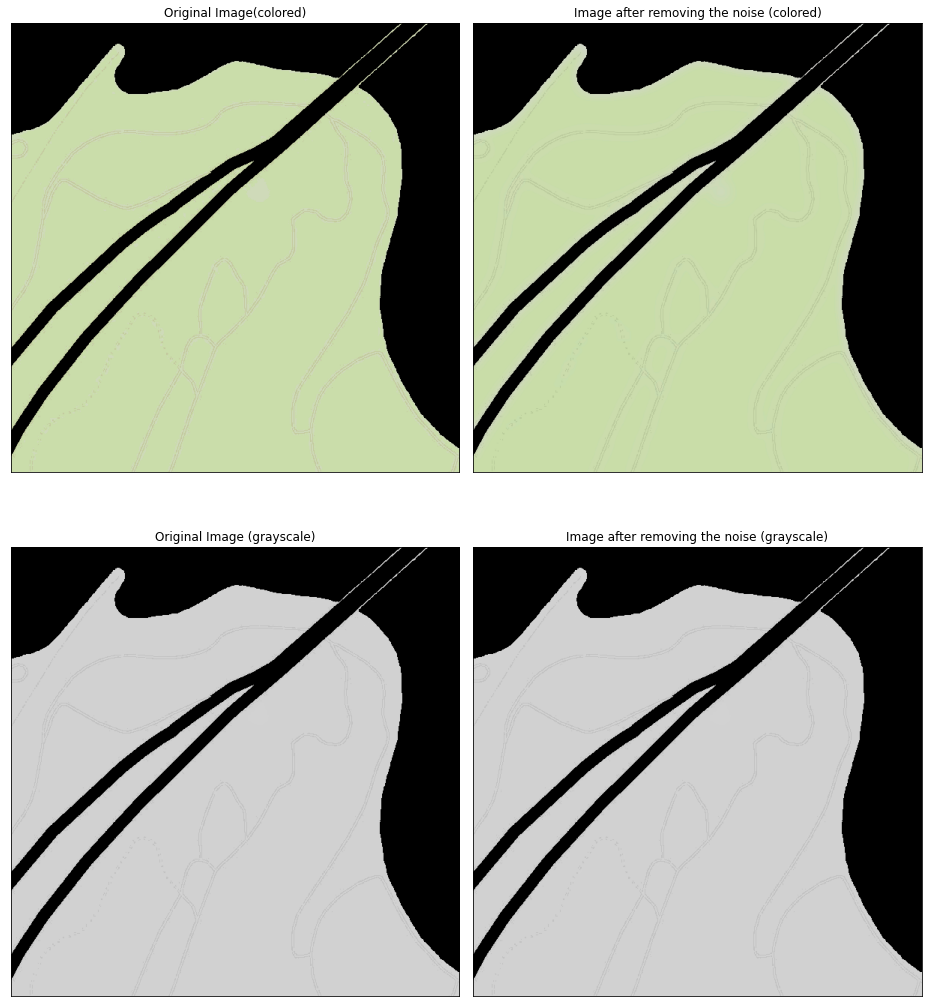

True

In [57]:
frame = cv2.imread('your_file.png')
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Порог белого в пространстве HSV
lower_gray = np.array([196, 201, 158])
upper_gray = np.array([255, 255, 255])

# подготовка маски к нанесению
mask = cv2.inRange(hsv, lower_gray, upper_gray)
cv2.imwrite('mask.png', mask)
# Черная область в маске имеет значение 0,
# поэтому при умножении на исходное изображение удаляются все не синие области
result = cv2.bitwise_and(frame, frame, mask = mask)
 
#cv2.imwrite('frame.png', frame)
#cv2.imwrite('mask.png', mask)
cv2.imwrite('result.png', result)
image = cv2.imread('result.png',1) 

image_bw = cv2.imread('result.png',0) 

noiseless_image_bw = cv2.fastNlMeansDenoising(image_bw, None, 0, 0, 0)

noiseless_image_colored = cv2.fastNlMeansDenoisingColored(image,None,0,20,20,20)

titles = ['Original Image(colored)','Image after removing the noise (colored)', 'Original Image (grayscale)','Image after removing the noise (grayscale)']
images = [image,noiseless_image_colored, image_bw, noiseless_image_bw]
plt.figure(figsize=(13,15))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(cv2.cvtColor(images[i],cv2.COLOR_BGR2RGB))
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

# Резкость изображения
kernel = np.array([[-1, -1, -1],[-1, 8, -1],[-1, -1, 0]], np.float32) 
dst = cv2.filter2D(noiseless_image_colored, -1, kernel)

# Обнаружение хитрых краев
canny = cv2.Canny(dst, 30, 10, 1)
ret, binary = cv2.threshold(noiseless_image_colored,127,255,cv2.THRESH_BINARY)

# Найти контуры
cnts= cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

# Итерация по контурам и рисование прямоугольников вокруг контуров
#for c in cnts:
#   x,y,w,h = cv2.boundingRect(c)
   

#    cv2.rectangle(image, (x, y), (x + w, y + h), (20,0,255), 1)

cv2.drawContours(noiseless_image_colored,cnts,-1,(255,0,0),0)
# вывод
cv2.imwrite('maskimageroad.png', noiseless_image_colored)

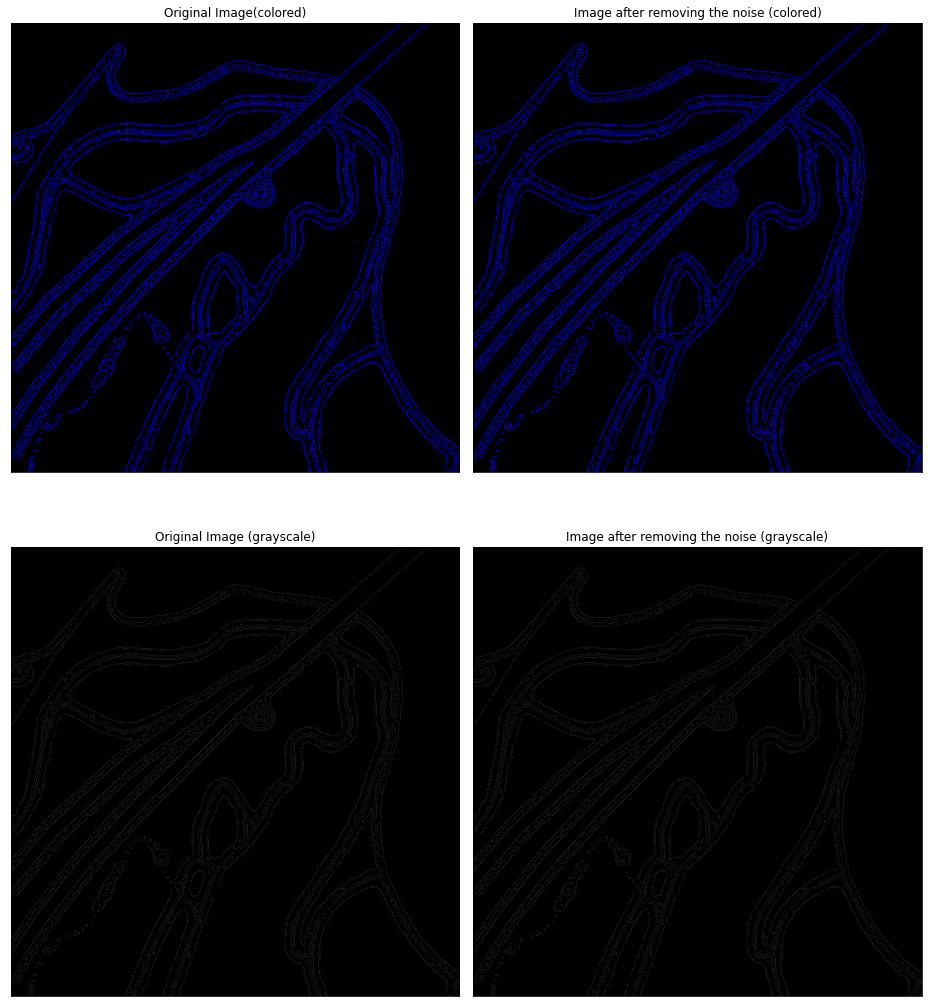

True

In [58]:
frame = cv2.imread('maskimageroad.png')
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Порог белого в пространстве HSV
lower_gray = np.array([0, 0, 255])
upper_gray = np.array([255, 255, 255])

# подготовка маски к нанесению
mask = cv2.inRange(hsv, lower_gray, upper_gray)
cv2.imwrite('mask.png', mask)
# Черная область в маске имеет значение 0,
# поэтому при умножении на исходное изображение удаляются все не синие области
result = cv2.bitwise_and(frame, frame, mask = mask)
 
#cv2.imwrite('frame.png', frame)
#cv2.imwrite('mask.png', mask)
cv2.imwrite('result.png', result)
image = cv2.imread('result.png',1) 

image_bw = cv2.imread('result.png',0) 

noiseless_image_bw = cv2.fastNlMeansDenoising(image_bw, None, 0, 0, 0)

noiseless_image_colored = cv2.fastNlMeansDenoisingColored(image,None,0,0,0,0)

titles = ['Original Image(colored)','Image after removing the noise (colored)', 'Original Image (grayscale)','Image after removing the noise (grayscale)']
images = [image,noiseless_image_colored, image_bw, noiseless_image_bw]
plt.figure(figsize=(13,15))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(cv2.cvtColor(images[i],cv2.COLOR_BGR2RGB))
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

# Резкость изображения
kernel = np.array([[-1, -1, -1],[-1, 8, -1],[-1, -1, 0]], np.float32) 
dst = cv2.filter2D(noiseless_image_colored, -1, kernel)

# Обнаружение хитрых краев
canny = cv2.Canny(dst, 30, 10, 1)
ret, binary = cv2.threshold(noiseless_image_colored,127,255,cv2.THRESH_BINARY)

# Найти контуры
cnts = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
cnts_roads  = cnts[0] if len(cnts) == 2 else cnts[1]

# Итерация по контурам и рисование прямоугольников вокруг контуров
#for c in cnts:
#   x,y,w,h = cv2.boundingRect(c)
   

#    cv2.rectangle(image, (x, y), (x + w, y + h), (20,0,255), 1)

cv2.drawContours(noiseless_image_colored,cnts_roads,-1,(0,0,255),1)
# вывод
cv2.imwrite('resultimageroad.png', noiseless_image_colored)

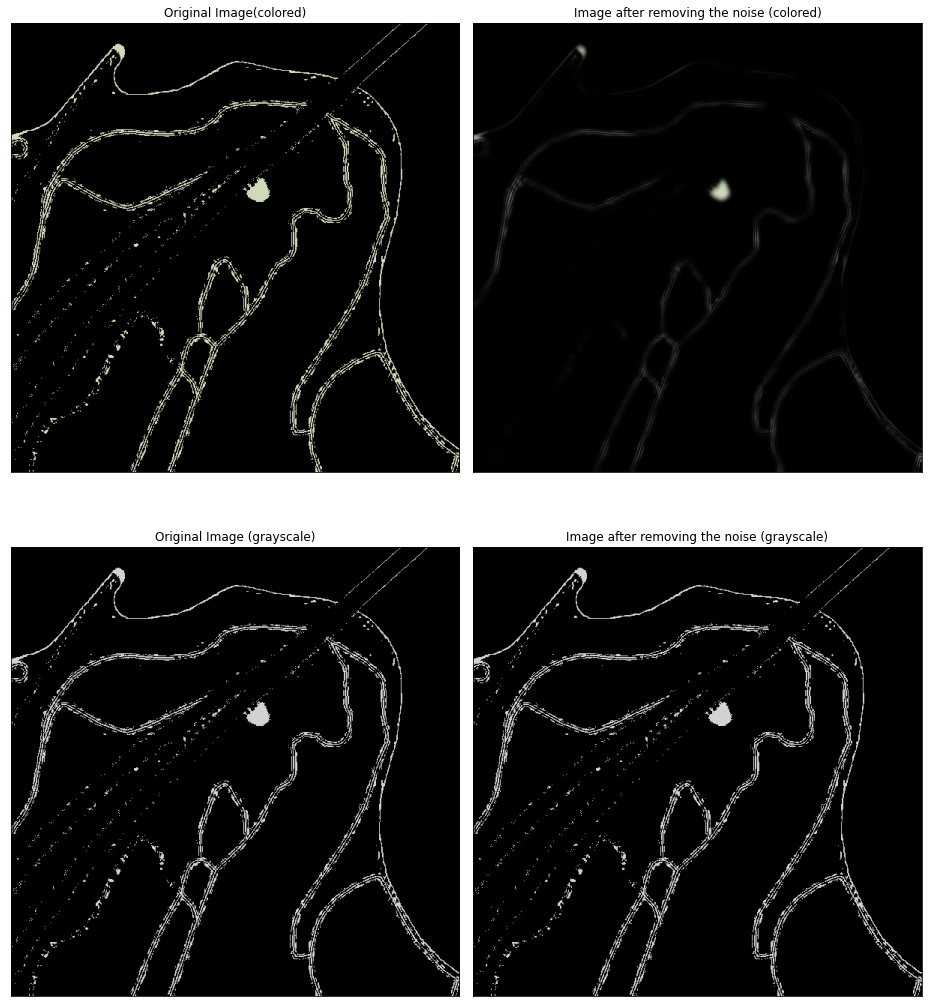

True

In [59]:
frame = cv2.imread('your_file.png')
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Порог белого в пространстве HSV
lower_white = np.array([207, 218, 185])
upper_white = np.array([255, 255, 255])
# подготовка маски к нанесению
mask = cv2.inRange(hsv, lower_white, upper_white)
cv2.imwrite('mask.png', mask)
# Черная область в маске имеет значение 0,
# поэтому при умножении на исходное изображение удаляются все не синие области
result = cv2.bitwise_and(frame, frame, mask = mask)
 
#cv2.imwrite('frame.png', frame)
#cv2.imwrite('mask.png', mask)
cv2.imwrite('result.png', result)
image = cv2.imread('result.png',1) 

image_bw = cv2.imread('result.png',0) 

noiseless_image_bw = cv2.fastNlMeansDenoising(image_bw, None, 0, 0, 0)

noiseless_image_colored = cv2.fastNlMeansDenoisingColored(image,None,63,30,30,17) 

titles = ['Original Image(colored)','Image after removing the noise (colored)', 'Original Image (grayscale)','Image after removing the noise (grayscale)']
images = [image,noiseless_image_colored, image_bw, noiseless_image_bw]
plt.figure(figsize=(13,15))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(cv2.cvtColor(images[i],cv2.COLOR_BGR2RGB))
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

# Резкость изображения
kernel = np.array([[-1, -1, -1],[-1, 8, -1],[-1, -1, 0]], np.float32) 
dst = cv2.filter2D(noiseless_image_colored, -1, kernel)

# Обнаружение хитрых краев
canny = cv2.Canny(dst, 100, 300, 10)
ret, binary = cv2.threshold(noiseless_image_colored,127,255,cv2.THRESH_BINARY)

# Найти контуры
cnts = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

# Итерация по контурам и рисование прямоугольников вокруг контуров
#for c in cnts:
#   x,y,w,h = cv2.boundingRect(c)
#   cv2.rectangle(image, (x, y), (x + w, y + h), (20,0,255), 1)

cv2.drawContours(noiseless_image_colored,cnts,1,(0,0,255),1)
# вывод
cv2.imwrite('maskimagehouse.png', noiseless_image_colored)



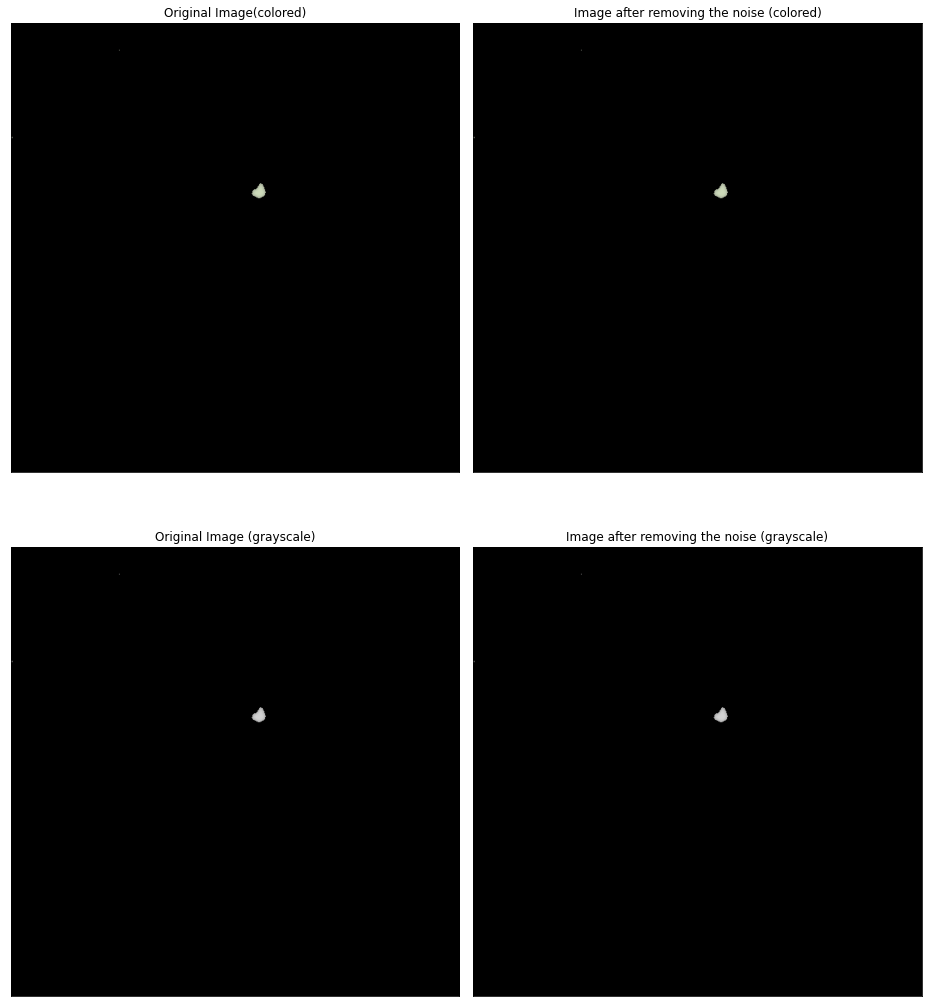

True

In [60]:

frame = cv2.imread('maskimagehouse.png')
hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Порог белого в пространстве HSV
lower_white = np.array([156, 163, 148])
upper_white = np.array([255, 255, 255])
# подготовка маски к нанесению
mask = cv2.inRange(hsv, lower_white, upper_white)
cv2.imwrite('maskhouse.png', mask)
# Черная область в маске имеет значение 0,
# поэтому при умножении на исходное изображение удаляются все не синие области
result = cv2.bitwise_and(frame, frame, mask = mask)
 
#cv2.imwrite('frame.png', frame)
#cv2.imwrite('mask.png', mask)
cv2.imwrite('resulthouse.png', result)
image = cv2.imread('resulthouse.png',1) 

image_bw = cv2.imread('resulthouse.png',0) 

noiseless_image_bw = cv2.fastNlMeansDenoising(image_bw, None, 0, 0, 0)

noiseless_image_colored = cv2.fastNlMeansDenoisingColored(image,None,0,0,0,0) 

titles = ['Original Image(colored)','Image after removing the noise (colored)', 'Original Image (grayscale)','Image after removing the noise (grayscale)']
images = [image,noiseless_image_colored, image_bw, noiseless_image_bw]
plt.figure(figsize=(13,15))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(cv2.cvtColor(images[i],cv2.COLOR_BGR2RGB))
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

# Резкость изображения
kernel = np.array([[-1, -1, -1],[-1, 8, -1],[-1, -1, 0]], np.float32) 
dst = cv2.filter2D(noiseless_image_colored, -1, kernel)

# Обнаружение хитрых краев
canny = cv2.Canny(dst, 1, 3, 1)
ret, binary = cv2.threshold(noiseless_image_colored,127,255,cv2.THRESH_BINARY)

# Найти контуры
cnts = cv2.findContours(canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
cnts_buildings = cnts[0] if len(cnts) == 2 else cnts[1]

# Итерация по контурам и рисование прямоугольников вокруг контуров
#for c in cnts:
#   x,y,w,h = cv2.boundingRect(c)
#   cv2.rectangle(image, (x, y), (x + w, y + h), (20,0,255), 1)

cv2.drawContours(noiseless_image_colored,cnts_buildings,1,(255,255,0),2)
# вывод
cv2.imwrite('resultimagehouse.png', noiseless_image_colored)

In [94]:
import xml.etree.ElementTree as et

class Way:
    def __init__(self, id, tags):
        self.id: int = id
        self.node_ids: 'list[int]' = []
        self.tags: dict = tags


class OSM:
    def __init__(self, minlat=0, minlon=0, maxlat=1, maxlon=1):
        self.minlat = minlat
        self.minlon = minlon
        self.maxlat = maxlat
        self.maxlon = maxlon
        self.nodes = []
        self.ways: 'list[Way]' = []
        self.index = 1000
        
    def add_way(self, width, height, nodes_coords, tags, area=False):
        w = Way(self.index, tags)
        self.index += 1
        first = None
        for idx, node in enumerate(nodes_coords):
            x, y = node
            lat = 1 / height * (height - y) * (self.maxlat - self.minlat)
            lon = 1 / width * x * (self.maxlon - self.minlon)
            n = {'id': str(self.index), 'version': '1', 'lat': str(lat), 'lon': str(lon)}
            self.nodes.append(n)
            if idx == 0:
                first = self.index
            w.node_ids.append(self.index)
            self.index += 1
        if area and first:
            w.node_ids.append(first)
        self.ways.append(w)

    def add_area(self, width, height, nodes_coords, tags):
        return self.add_way(width, height, nodes_coords, tags, area=True)
        
    def get_xml(self):
        root = et.Element('osm', {'version': '0.6'})
        dict = {'minlat': self.minlat, 'minlon': self.minlon, 'maxlat': self.maxlat, 'maxlon': self.maxlon}
        dict = { k: str(v) for (k, v) in dict.items()}
        et.SubElement(root, 'bounds', dict)

        for node in self.nodes:
            et.SubElement(root, 'node', node)

        for way in self.ways:
            way_el = et.SubElement(root, 'way', {'id': str(way.id), 'version': '1'})
            for node_id in way.node_ids:
                et.SubElement(way_el, 'nd', {'ref': str(node_id)})
            for k, v in way.tags.items():
                et.SubElement(way_el, 'tag', {'k': str(k), 'v': str(v)})

        return et.ElementTree(root)

In [96]:
%%capture
osm = OSM(0, 0, 1, 1)
width, height, _ = image.shape

for cnt in cnts_buildings:
    if (len(cnt) <= 4):
        continue
    points = [x[0] for x in cnt]
    osm.add_area(width, height, points, {'building': 'yes'})

for cnt in cnts_highways:
    points = [x[0] for x in cnt]
    osm.add_way(width, height, points, {'highway': 'primary'})

#for cnt in cnts_roads:
#    points = [x[0] for x in cnt]
#    osm.add_way(width, height, points, {'highway': 'unclassified'})

for cnt in cnts_water:
    points = [x[0] for x in cnt[::-1]]
    osm.add_area(width, height, points, {'natural': 'water'})
    
xml = osm.get_xml()
xml.write('megatest.osm')